# Software Evolution - Practical Session
## Laws of software evolution, code counting, code duplication and dependency analysis
## Academic year 2022-2023

### Write your answers under the questions that are present in this notebook  

### Read Section 1 and Section 2 in the provided description document before proceeding with the following section 

In [2]:
import os
import json
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import subprocess
import math
from pandas import option_context
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from io import StringIO

## 2. Verifying laws of software evolution

In [3]:
#Enter the path where the Eucalyptus project is present
eucalyptus_project_path = '../../IdeaProjects/eucalyptus'

### 2.1 Data prepocessing
1. Get all the tags present in the eucalyptus project using CLOC
2. Filter out the tags that do not correspond to official releases

Code hint:  
To get the tags that are present in the project - "command = f'git -C {eucalyptus_project_path} tag -l --format="%(refname:short)" | sort -r'"   
To read the terminal output - 'process = subprocess.Popen(command, stdout=subprocess.PIPE, shell=True)'

In [4]:
command = f'git -C {eucalyptus_project_path} tag -l --format="%(refname:short)" | sort -r'
process = subprocess.Popen(command, stdout=subprocess.PIPE, shell=True)
all_tags= list(line.strip().decode("utf-8") for line in process.stdout)
print(all_tags)

['v4.4.2', 'v4.4.1', 'v4.4.0', 'v4.3.1.1', 'v4.3.1', 'v4.3.0.1', 'v4.3.0', 'v4.2.2', 'v4.2.1', 'v4.2.0', 'v4.1.2', 'v4.1.1', 'v4.1.0', 'v4.0.2', 'v4.0.1', 'v4.0.0', 'karmic', 'jaunty', 'ha-baseline', '3.4.2', '3.4.1', '3.4.0', '3.3.2', '3.3.1', '3.3.0.1', '3.3.0', '3.3-m6', '3.3-m5', '3.3-m4', '3.3-m3', '3.3-m2', '3.3-m1', '3.2.2', '3.2.1', '3.2.0', '3.1.2', '3.1.1', '3.1.0', '3.1-beta1', '3.1-alpha2', '3.0.1', '3.0.0', '3.0-rc3', '3.0-rc2', '3.0-rc1', '3.0-beta6', '3.0-beta5', '3.0-beta4', '3.0-beta3', '3.0-beta2', '3.0-alpha1', '2.0.1', '2.0.0', '2.0-branch', '2.0-beta', '1.6.1', '1.5.2', '1.5.1', '1.5.0', '1.4', '1.0-beta']


In [5]:
import re
r = r'^v?[0-9]+\.[0-9]+(\.[0-9]+)?$'
r=re.compile(r)
all_tags=[tag for tag in all_tags if r.match(tag)]
major_minor_patch_versions = []
major_minor_patch_versions = list(reversed([tag for tag in all_tags if r.match(tag)]))
major_minor_versions = ['1.4','1.5.0','1.6.1','2.0.0','3.0.0','3.1.0','3.2.0','3.3.0','3.4.0','v4.0.0','v4.1.0','v4.2.0','v4.3.0','v4.4.0']
print(major_minor_patch_versions)
print(major_minor_versions)
print(all_tags)

['1.4', '1.5.0', '1.5.1', '1.5.2', '1.6.1', '2.0.0', '2.0.1', '3.0.0', '3.0.1', '3.1.0', '3.1.1', '3.1.2', '3.2.0', '3.2.1', '3.2.2', '3.3.0', '3.3.1', '3.3.2', '3.4.0', '3.4.1', '3.4.2', 'v4.0.0', 'v4.0.1', 'v4.0.2', 'v4.1.0', 'v4.1.1', 'v4.1.2', 'v4.2.0', 'v4.2.1', 'v4.2.2', 'v4.3.0', 'v4.3.1', 'v4.4.0', 'v4.4.1', 'v4.4.2']
['1.4', '1.5.0', '1.6.1', '2.0.0', '3.0.0', '3.1.0', '3.2.0', '3.3.0', '3.4.0', 'v4.0.0', 'v4.1.0', 'v4.2.0', 'v4.3.0', 'v4.4.0']
['v4.4.2', 'v4.4.1', 'v4.4.0', 'v4.3.1', 'v4.3.0', 'v4.2.2', 'v4.2.1', 'v4.2.0', 'v4.1.2', 'v4.1.1', 'v4.1.0', 'v4.0.2', 'v4.0.1', 'v4.0.0', '3.4.2', '3.4.1', '3.4.0', '3.3.2', '3.3.1', '3.3.0', '3.2.2', '3.2.1', '3.2.0', '3.1.2', '3.1.1', '3.1.0', '3.0.1', '3.0.0', '2.0.1', '2.0.0', '1.6.1', '1.5.2', '1.5.1', '1.5.0', '1.4']


### 2.2 Law of Increasing Growth
1. Fetch the required data (lines of code, blank lines, comment lines and number of files) for each tag along with their release date using CLOC
2. Separate the data as following (also mentioned in section 2.1 of the description document)  
    a) Consider all the three-component versions (major.minor.patch) - Dataset A  
    b) Consider only the minor versions (major.minor) - Dataset B  

Note: For example, if there exists any tag like 2.1.0.1, then you can consider it as 2.1.0 provided such a tag does not exist in the data. If both 2.1.0 and 2.1.0.1 exists, then you can ignore the latter 

Code hint:  
To set the project to a required tag - "command = f'git -C {project_path} reset --hard {tag}'"  
For each tag, pass the command to the terminal, invoke cloc tool to get the necessary data in the required format (json, md,...), read the terminal output and store the data

In [6]:
major_minor_patch_d = {}
major_minor_d = {}

for tag in tqdm(major_minor_patch_versions):
    command = f'git -C {eucalyptus_project_path} reset --hard {tag}'
    process = subprocess.Popen(command, stdout=subprocess.PIPE, shell=True).wait()
    command = f'/Users/goffinetnicolas/IdeaProjects/cloc/cloc {eucalyptus_project_path} --csv --timeout=10'
    process = subprocess.Popen(command, stdout=subprocess.PIPE, shell=True)
    outs, err = process.communicate()
    outs = "\n".join(outs.decode('utf-8').split("\n")[4:])
    d = pd.read_csv(StringIO(outs))
    major_minor_patch_d[tag] = d
    if tag in major_minor_versions:
        major_minor_d[tag]=d
print(major_minor_patch_d)
print(major_minor_d)

Updating files: 100% (4132/4132), done.pdating files:  63% (2609/4132)Updating files:  79% (3265/4132)Updating files:  90% (3719/4132)Updating files:  93% (3843/4132)Updating files:  96% (3967/4132)
Updating files: 100% (1111/1111), done.07s/it]Updating files:  83% (930/1111)
Updating files: 100% (2335/2335), done.70s/it]Updating files:  78% (1824/2335)Updating files:  95% (2219/2335)
Updating files: 100% (2179/2179), done..93s/it]Updating files:  84% (1839/2179)Updating files:  98% (2136/2179)
Updating files: 100% (2384/2384), done..82s/it]Updating files:  99% (2378/2384)
100%|██████████| 35/35 [04:42<00:00,  8.08s/it]


{'1.4':     files                  language  blank  comment   code  \
0     235                      Java   4076     6750  21281   
1       9              Bourne Shell   1400     1045   9866   
2      29                         C   1798      598   8914   
3      70                       XML    346     1653   3189   
4      15                    Groovy    442      114   1766   
5       3  Web Services Description    188       37   1139   
6      18              C/C++ Header    147       57    575   
7       6                      Perl     60       53    452   
8      13                       Ant     28      452    384   
9      10                      make    131       64    332   
10      3        Bourne Again Shell     18       25    237   
11      1                        m4     20        1    163   
12      1                       CSS     17        0    114   
13      1                       XSD     12       33     99   
14      3                Properties     29      215     35   


#### Visualization
1. x-axis = version, y-axis = number  
    i) for tags of the type major.minor.patch  
    ii) for tags of the type major.minor  

2. x-axis = date, y-axis = number  
    i) for tags of the type major.minor.patch  
    ii) for tags of the type major.minor  

For easy comparison, place the plots with the versions on x-axis should be on the top (0,0) and (1,0) and their corresponding plots with date on the x-axis right below them (1,0) and (1,1) 

    Unnamed: 0  major  minor  patch  nb_code  nb_blank  nb_comment  nb_nfiles  \
0            0      1      4      0   115336     18033       37569       1624   
1            1      1      5      0   129319     20261       44820       1705   
2            2      1      5      1   133424     20780       44377       1784   
3            3      1      5      2   134275     20719       38184       1796   
4            4      1      6      1   152705     23755       65761       1923   
5            5      2      0      0   181316     27549       67567       2251   
6            6      2      0      1   181826     27681       67584       2255   
7            7      3      0      0   255305     39181       87179       2894   
8            8      3      0      1   256081     39290       87887       2896   
9            9      3      1      0   258194     39307       88912       2837   
10          10      3      1      1   258951     39420       89215       2840   
11          11      3      1

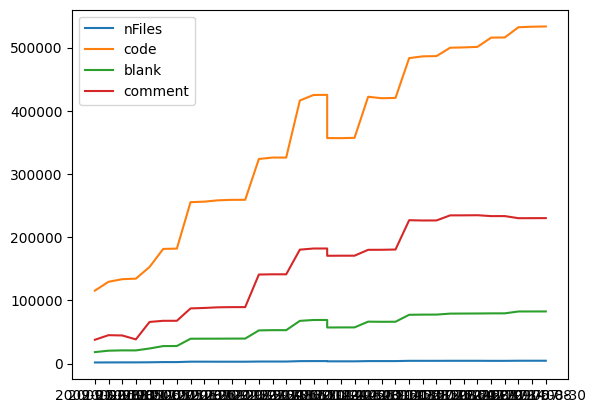

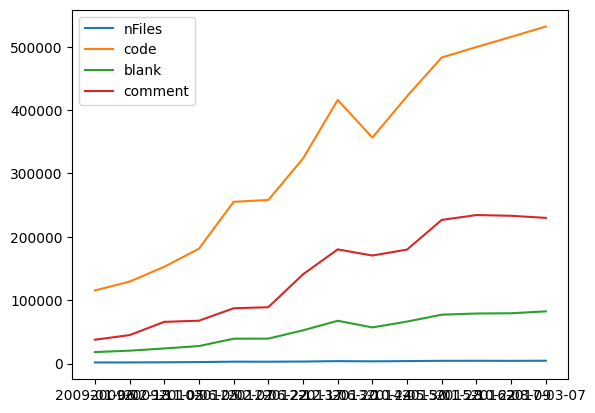

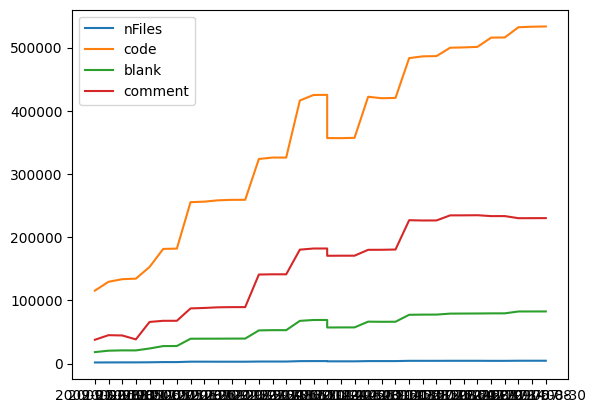

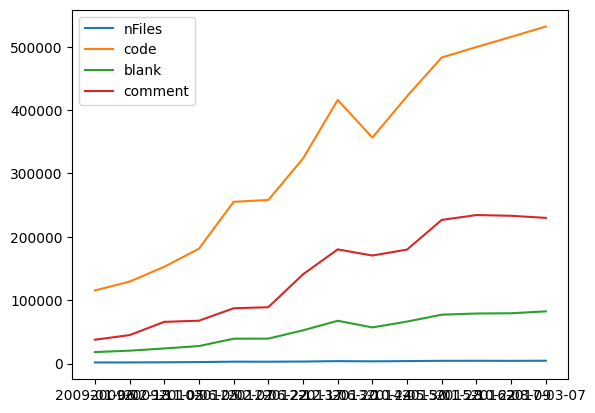

In [7]:

data = pd.read_csv('LIG_major_minor_patch.csv')
data2 = pd.read_csv('LIG_major_minor.csv')

print(data)
print(data2)

plt.plot(data['date'], data['nb_nfiles'], label='nFiles')
plt.plot(data['date'], data['nb_code'], label='code')
plt.plot(data['date'], data['nb_blank'], label='blank')
plt.plot(data['date'], data['nb_comment'], label='comment')
plt.legend()

plt.show()

plt.plot(data2['date'], data2['nb_nfiles'], label='nFiles')
plt.plot(data2['date'], data2['nb_code'], label='code')
plt.plot(data2['date'], data2['nb_blank'], label='blank')
plt.plot(data2['date'], data2['nb_comment'], label='comment')
plt.legend()

plt.show()

plt.plot(data['date'], data['nb_nfiles'], label='nFiles')
plt.plot(data['date'], data['nb_code'], label='code')
plt.plot(data['date'], data['nb_blank'], label='blank')
plt.plot(data['date'], data['nb_comment'], label='comment')
plt.legend()

plt.show()

plt.plot(data2['date'], data2['nb_nfiles'], label='nFiles')
plt.plot(data2['date'], data2['nb_code'], label='code')
plt.plot(data2['date'], data2['nb_blank'], label='blank')
plt.plot(data2['date'], data2['nb_comment'], label='comment')
plt.legend()

plt.show()

### Questions:
1. Do you find any difference between the plot that is having date in the x-axis and the plot that is having tag in the x-axis? If yes, then what is the difference? If no, then why is it same?

Yes, we can notice a difference in the x-axis. The scale is not the same because there are different versions

2. Which type of plot is preferable for software evolution analysis?   
    a) date in x-axis  
    b) tag in x-axis  
Why?

a) we prefer date because it is easier to read and understand

3. Choose an option regarding the growth of the software by considering Dataset A. Motivate your choice using a 1d regression plot (below).  
    a) Linear  
    b) Sub-linear  
    c) Super-linear

It is linear. Here is the code for the linear regression

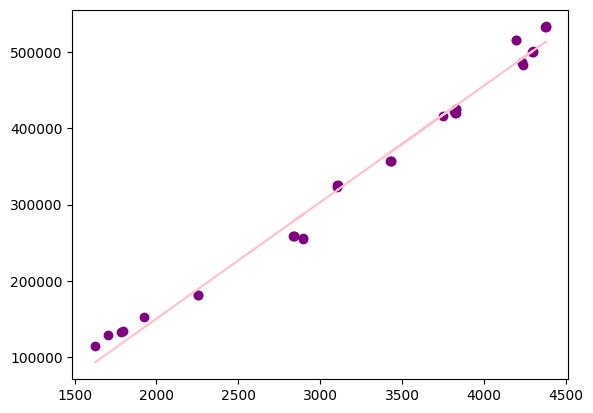

In [8]:
# Your code for regression plot
d = data[['nb_nfiles', 'nb_code', 'nb_blank', 'nb_comment']]
d.head()

x = d['nb_nfiles'].values.reshape(-1,1)
y = d['nb_code'].values

reg = LinearRegression().fit(x,y)
plt.scatter(x,y, color='purple')
plt.plot(x, reg.predict(x), color='pink')
plt.show()

### Correlation 
Correlation is generally used to analyse the relationship between variables. Here, analyse the relationship between the number of lines of code and the number of files using Spearman correlation and Pearson correlation by considering Dataset A. Report the correlation upto 3 decimal places

In [9]:
# Your code for correlation
c1 = d[['nb_code','nb_nfiles']].corr(method='pearson')
c2 = d[['nb_code','nb_nfiles']].corr(method='spearman')
print(c1)
print(c2)

            nb_code  nb_nfiles
nb_code    1.000000   0.993107
nb_nfiles  0.993107   1.000000
            nb_code  nb_nfiles
nb_code    1.000000   0.977165
nb_nfiles  0.977165   1.000000


### Questions:
4. Do you find any difference in correlation values between Pearson and Spearman? Which one is preferable for this use case? why?

There are many differences but both are good to check how the data is correlated. In this case we can prefer pearson.

5. Based on the above correlation value, how much is the number of lines of code related to the number of files?

There is a strong relation between these values, it is close to 0.99

### Prediction
Consider Dataset A for this task. Drop the last two data points in "number of lines of code" (LOC) (i.e. drop (LOC) corresponding to v4.4.1 and v4.4.2) and forecast the values for (LOC) for v4.4.1 and v4.4.2 using a basic linear/polynimial regression model.
1. Drop the last two data points
2. Build a basic regression model
3. Ask the model to forecast the next two data points
4. Plot the LOC original and forecasted in the same plot. x-axis = date, y-axis = number of lines of code

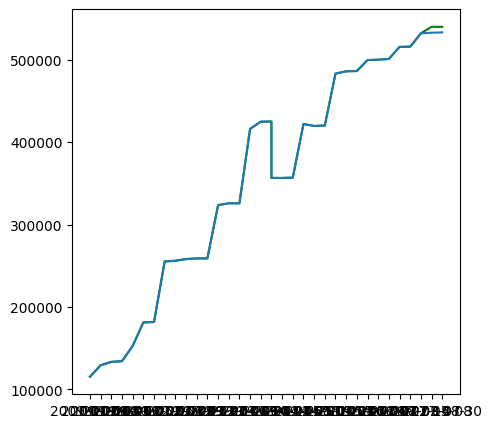

In [10]:
# Your code here
train = data.iloc[:-2]
test = data.iloc[-2:]
reg = LinearRegression()
reg = reg.fit(train[['major', 'minor', 'patch']], train['nb_code'])
res = reg.predict(test[['major', 'minor', 'patch']])
plt.figure(figsize=(5,5))
pred= np.concatenate((train['nb_code'].values, res))
plt.plot(data['date'], pred, color='green')
plt.plot(data['date'], data['nb_code'])

### Questions:
6. What is the polynomial degree that you adopted to build the model? Why? 

It is degree 1 because the data is well correlated.

7. What is the coefficient of determination? (R-squared)

In [11]:
rs = reg.score(test[['major', 'minor', 'patch']], test['nb_code'])
print(rs)

6933.230868741266


8. What is the Root mean square error for the forecasted values?

In [ ]:
import sklearn

coef_det = sklearn.metrics.mean_squared_error(test['nb_code'], res, squared=False)
print(coef_det)

### Filtering on coding langugage

Consider the prominent langugages used in this software project and plot the distribution of their LOC in a pie chart for the first and the last versions

Updating files: 100% (4132/4132), done.


([<matplotlib.patches.Wedge at 0x120f01b50>,
 [Text(-0.5183015126281815, 0.9702389097574572, 'Java'),
  Text(0.29757947420229425, -1.0589836904001337, 'C'),
  Text(1.0623712292288294, -0.2852496648671583, 'Groovy'),
  Text(1.0987611387549412, -0.05219156983599117, 'Perl'),
  Text(1.0999981372819638, -0.002024345872087141, 'HTML')])

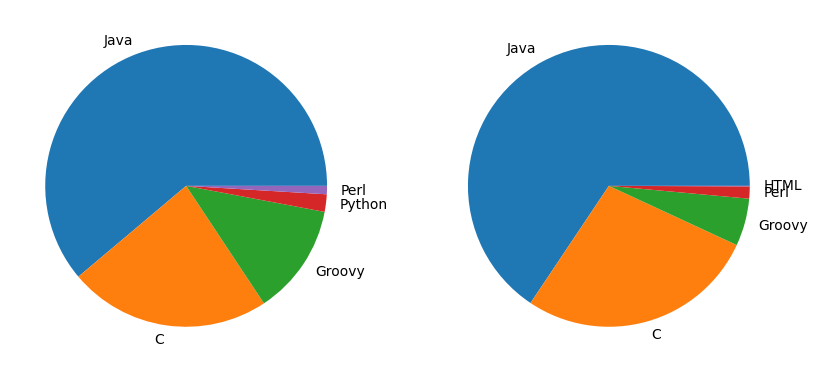

In [14]:
command = f'git -C {eucalyptus_project_path} reset --hard {all_tags[-1]}'
subprocess.Popen(command, stdout=subprocess.PIPE, shell=True)
command = f'/Users/goffinetnicolas/IdeaProjects/cloc/cloc {eucalyptus_project_path} --csv'
process=subprocess.Popen(command, stdout=subprocess.PIPE, shell=True)
outs, err = process.communicate()
outs = "\n".join(outs.decode().split("\n")[4:])
outs2 = pd.read_csv(StringIO(outs))

command = f'git -C {eucalyptus_project_path} reset --hard {all_tags[0]}'
subprocess.Popen(command, stdout=subprocess.PIPE, shell=True)
command = f'/Users/goffinetnicolas/IdeaProjects/cloc/cloc {eucalyptus_project_path} --csv'
process=subprocess.Popen(command, stdout=subprocess.PIPE, shell=True)
outs, err = process.communicate()
outs = "\n".join(outs.decode().split("\n")[4:])
outs3 = pd.read_csv(StringIO(outs))

lang=['Python', 'Java', 'C', 'Groovy', 'Perl', 'HTML']
outs2 = outs2[outs2['language'].isin(lang)]
outs3 = outs3[outs3['language'].isin(lang)]
fig,axes=plt.subplots(1,2, figsize=(10,5))
axes[0].pie(outs3['code'], labels=outs3['language'])
axes[1].pie(outs2['code'], labels=outs2['language'])


### Question:
9. Do you find any significant difference in the distribution of the language used in the software project between its first and the last version? If so, what is the difference and how much is it?

We can see that there are large differences in the pie. C has lost distribution and java has now a good portion.

### Law of increasing growth for coding langugages

Get the LOC for each of the considered prominent langugages (as above) for each version of the form major.minor.patch  
1) Plot the date (x-axis) vs LOC (y-axis) 
2) Plot the date (x-axis) vs proportional LOC (y-axis). Proportional is LOC of a language/total number of LOC

In [22]:
# Your code to get# Your code to get the LOC for each prominent language of each version
dataLOC = {}
for tag in tqdm(major_minor_patch_versions):
    command = f'git -C {eucalyptus_project_path} reset --hard {tag}'
    subprocess.Popen(command, stdout=subprocess.PIPE, shell=True)
    command = f'/Users/goffinetnicolas/IdeaProjects/cloc/cloc {eucalyptus_project_path} --csv '
    process = subprocess.Popen(command, stdout=subprocess.PIPE, shell=True)
    outs, err = process.communicate()
    outs = "\n".join(outs.decode().split("\n")[4:])
    d = pd.read_csv(StringIO(outs))
    dataLOC[tag] = d[d['language'].isin(lang)]

dataLOC = pd.concat(dataLOC)
dataLOC = data.reset_index()

Updating files: 100% (2335/2335), done.47s/it]Updating files:  92% (2153/2335)
Updating files: 100% (2179/2179), done..19s/it]Updating files:  78% (1701/2179)Updating files:  95% (2071/2179)
Updating files: 100% (2384/2384), done..51s/it]Updating files:  77% (1842/2384)Updating files:  94% (2241/2384)
 69%|██████▊   | 24/35 [02:22<01:31,  8.35s/it]
1 error:
Line count, exceeded timeout:  ../../IdeaProjects/eucalyptus/net/globalnetwork.c
 83%|████████▎ | 29/35 [03:11<00:57,  9.53s/it]
1 error:
Line count, exceeded timeout:  ../../IdeaProjects/eucalyptus/storage/diskutil.c
Updating files: 100% (1274/1274), done..51s/it]Updating files:  64% (820/1274)Updating files:  76% (969/1274)Updating files:  86% (1096/1274)Updating files:  92% (1173/1274)Updating files:  96% (1224/1274)
100%|██████████| 35/35 [04:33<00:00,  7.80s/it]

    index  Unnamed: 0  major  minor  patch  nb_code  nb_blank  nb_comment  \
0       0           0      1      4      0   115336     18033       37569   
1       1           1      1      5      0   129319     20261       44820   
2       2           2      1      5      1   133424     20780       44377   
3       3           3      1      5      2   134275     20719       38184   
4       4           4      1      6      1   152705     23755       65761   
5       5           5      2      0      0   181316     27549       67567   
6       6           6      2      0      1   181826     27681       67584   
7       7           7      3      0      0   255305     39181       87179   
8       8           8      3      0      1   256081     39290       87887   
9       9           9      3      1      0   258194     39307       88912   
10     10          10      3      1      1   258951     39420       89215   
11     11          11      3      1      2   259038     39435       89243   

In [20]:
data['date']=pd.to_datetime(data['date'])
x = data['date']
print(x)
for i in lang:
    y = data[data['language'] == i]['code']
    y += data[data['language'] == i]['comment']
    y += data[data['language'] == i]['blank']
    plt.plot(x[:len(y)], y, label=i)
plt.legend()

0    2009-01-06
1    2009-02-18
2    2009-08-05
3    2009-08-17
4    2009-11-05
5    2010-06-05
6    2010-07-06
7    2012-02-07
8    2012-03-12
9    2012-06-22
10   2012-09-17
11   2012-09-27
12   2012-12-17
13   2013-02-28
14   2013-04-16
15   2013-06-20
16   2013-09-11
17   2013-10-24
18   2013-10-24
19   2013-12-16
20   2014-02-25
21   2014-05-30
22   2014-08-04
23   2014-11-03
24   2015-01-28
25   2015-05-07
26   2015-07-28
27   2015-10-22
28   2015-12-07
29   2016-04-27
30   2016-08-09
31   2016-12-14
32   2017-03-07
33   2017-05-08
34   2017-08-30
Name: date, dtype: datetime64[ns]
    index  Unnamed: 0  major  minor  patch  nb_code  nb_blank  nb_comment  \
0       0           0      1      4      0   115336     18033       37569   
1       1           1      1      5      0   129319     20261       44820   
2       2           2      1      5      1   133424     20780       44377   
3       3           3      1      5      2   134275     20719       38184   
4       4           4

KeyError: 'language'

In [ ]:
x = data['date']
total = pd.DataFrame()
total['code'] = dataLOC.groupby('level_0')['code'].sum()
total['comment'] = dataLOC.groupby('level_0')['comment'].sum()
total['blank'] = dataLOC.groupby('level_0')['blank'].sum()

for i in lang:
    y = dataLOC[dataLOC['language'] == i][['level_0', 'code', 'comment', 'blank']]
    a = y.join(total, on='level_0', rsuffix='_total')
    total = a['code_total'] + a['comment_total'] + a['blank_total']
    all = a['code'] + a['comment'] + a['blank']
    plt.plot(x[:len(a)], all/total, label=i)

plt.legend()

### Question:
10. Does the prominent languages considered by you obey laws of increasing growth?

11. Does this software project obey the Law of Increasing Growth?

### Modify the CLOC parameters

1. Exclude all bank lines and verify if the Law of Increasing Growth still holds good for this filtering

In [ ]:
x = data['date']
for l in lang:
    y = dataLOC[dataLOC['language'] == l]['code']
    y = y + dataLOC[dataLOC['language'] == l]['comment']
    plt.plot(x[:len(y)], y, label=l)
plt.legend()

2. Exclude all comment lines and verify if the Law of Increasing Growth still holds good for this filtering

In [ ]:
# Your code and plot here

3. Exclude all non-code files (or consider prominent coding langugages used in the project) and and verify if the Law of Increasing Growth still holds good for this filtering

In [ ]:
# Your code and plot here

### 2.3 Law of Continuing Change
1. Using CLOC tool, find the features such as number of lines of code that are added, modified, removed and same between two consecutive versions
2. Consider all the three component versions (major.minor.patch) - Dataset A
3. Consider only the minor versions (major.minor) - Dataset B
4. Having all the features in the same plot, create two plots (one for Dataset A and another for Dataset B) the outcomes with date on x-axis and the number on y-axis.
5. Make a subplot of all the features

Code hint:  
For each pair of tags, set the original project to the required tag and the copy of the original project to the next tag.  
To get the required data in json format - "command = f'CLOC/cloc --git --diff {first_project_path} {second_project_path} --json'"

In [1]:
eucalyptus_project_path = '../../IdeaProjects/eucalyptus' # your project path here
eucalyptus_copy_project_path = '../../IdeaProjects/eucalyptuscopy' # your path to the copy of your project here
major_minor_patch_versions = '3.1.0' #set of version that you would like to consider for this analysis

In [3]:
# Your code here to get the data
command = f'git -C {eucalyptus_project_path} reset --hard {major_minor_patch_versions}'
subprocess.Popen(command, stdout=subprocess.PIPE, shell=True)
command = f'git -C {eucalyptus_copy_project_path} reset --hard {major_minor_patch_versions}'
subprocess.Popen(command, stdout=subprocess.PIPE, shell=True)
command = f'/Users/goffinetnicolas/IdeaProjects/cloc/cloc --git --diff {eucalyptus_project_path} {eucalyptus_copy_project_path} --csv'
process = subprocess.Popen(command, stdout=subprocess.PIPE, shell=True)
outs = process.communicate()[0].decode()

NameError: name 'subprocess' is not defined

In [ ]:
# Your code here to get the dates corresponding to the tags

In [ ]:
# Your plotting code here (all the features in a single plot)

In [ ]:
# Your plotting code here, different plot for each feature
fig,axes = plt.subplots(2,2)

### Questions:
1. Do you find the Law of Continuing Change holding good here? Prove it empirically.

2. Does the law of increasing growth too hold good here?

### Law of continuing change for coding languages
Consider the prominent languages used in this software project for versions of the form major.minor.patch
1. Obtain the number of lines of code that are added, modified, removed and same between two consecutive versions
2. Make plots for each parameter (added, modified, removed and same) with date on x-axis  
    a) y-axis number of lines of code   
    b) y-axis proportional number of lines of code (number of lines of code of that language/total number of lines of code) 

In [ ]:
# Your code here
copy = '3.1.1'
command = f'git -C {eucalyptus_project_path} reset --hard {major_minor_patch_versions}'
subprocess.Popen(command, stdout=subprocess.PIPE, shell=True)

command = f'git -C {eucalyptus_copy_project_path} reset --hard {copy}'
subprocess.Popen(command, stdout=subprocess.PIPE, shell=True)

command = f'cloc --git --diff {eucalyptus_project_path} {eucalyptus_copy_project_path} --csv'
process = subprocess.Popen(command, stdout=subprocess.PIPE, shell=True)
output = process.communicate()[0].decode()


In [ ]:
# Your plotting code here
fig,axes = plt.subplots(2,2)

### Question:
3. Does the law of continuing change obey here for all the considered prominent langugages? Comment on the rate of growth.  

4. Does this software project obey Law of Continuing Change?